In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf

In [2]:
# --- Define Parameters ---

LOG_DIR = './logs'
TIMESTEPS = 5
RNN_UNITS = 50  # Number of units in the LSTM layer
DENSE_LAYERS = [10, 10]
TRAINING_STEPS = 100
BATCH_SIZE = 100
PRINT_STEPS = TRAINING_STEPS // 10
LEARNING_RATE = 0.03

# --- Generate Data ---

def generate_data(fct, x, timesteps, seperate=False):
    data = fct(x)
    X, y = [], []
    for i in range(len(data) - timesteps):
        X.append(data[i:i + timesteps])
        y.append(data[i + timesteps])
    split1 = int(0.6 * len(X))
    split2 = int(0.8 * len(X))
    return {
        'train': np.array(X[:split1]),
        'val': np.array(X[split1:split2]),
        'test': np.array(X[split2:])
    }, {
        'train': np.array(y[:split1]),
        'val': np.array(y[split1:split2]),
        'test': np.array(y[split2:])
    }

X, y = generate_data(np.sin, np.linspace(0, 100, 10000), TIMESTEPS)

Epoch 1/100
60/60 - 1s - 11ms/step - loss: 0.1058 - mae: 0.2106 - val_loss: 0.0042 - val_mae: 0.0529
Epoch 2/100
60/60 - 0s - 2ms/step - loss: 0.0027 - mae: 0.0413 - val_loss: 0.0019 - val_mae: 0.0343
Epoch 3/100
60/60 - 0s - 2ms/step - loss: 0.0015 - mae: 0.0300 - val_loss: 0.0013 - val_mae: 0.0285
Epoch 4/100
60/60 - 0s - 2ms/step - loss: 0.0011 - mae: 0.0264 - val_loss: 0.0010 - val_mae: 0.0255
Epoch 5/100
60/60 - 0s - 2ms/step - loss: 9.2531e-04 - mae: 0.0246 - val_loss: 8.6131e-04 - val_mae: 0.0238
Epoch 6/100
60/60 - 0s - 2ms/step - loss: 8.1182e-04 - mae: 0.0233 - val_loss: 7.5693e-04 - val_mae: 0.0223
Epoch 7/100
60/60 - 0s - 2ms/step - loss: 7.3034e-04 - mae: 0.0223 - val_loss: 6.9343e-04 - val_mae: 0.0213
Epoch 8/100
60/60 - 0s - 2ms/step - loss: 6.5340e-04 - mae: 0.0213 - val_loss: 6.1446e-04 - val_mae: 0.0202
Epoch 9/100
60/60 - 0s - 2ms/step - loss: 6.0025e-04 - mae: 0.0205 - val_loss: 5.7544e-04 - val_mae: 0.0202
Epoch 10/100
60/60 - 0s - 2ms/step - loss: 5.5673e-04 - mae

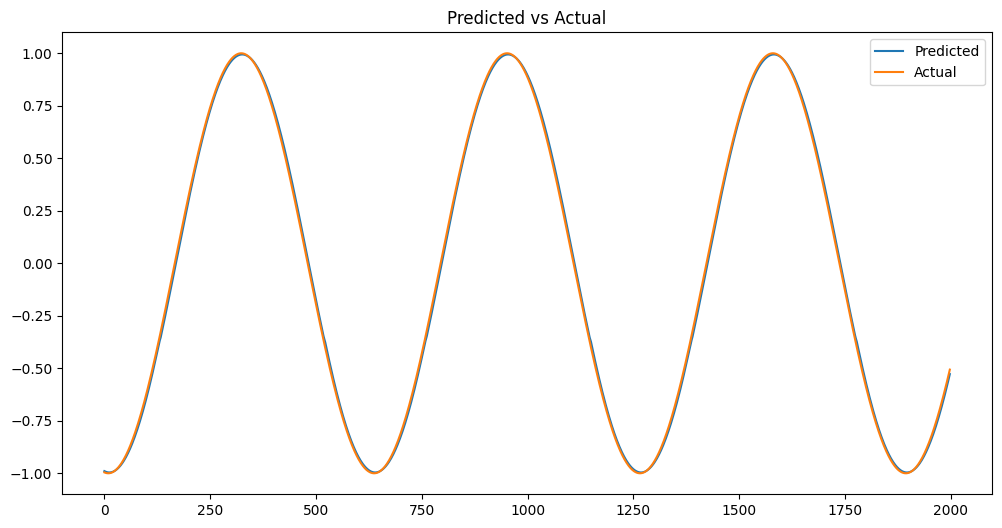

In [3]:
# --- Build LSTM Model ---

def build_lstm_model(timesteps, rnn_units, dense_layers):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(timesteps, 1)))
    model.add(tf.keras.layers.LSTM(rnn_units))
    for units in dense_layers:
        model.add(tf.keras.layers.Dense(units, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=LEARNING_RATE),
                  loss='mse',
                  metrics=['mae'])
    return model

# Reshape input for LSTM (samples, timesteps, features)
X_train = X['train'][..., np.newaxis]
X_val = X['val'][..., np.newaxis]
X_test = X['test'][..., np.newaxis]

# --- Create Model ---

model = build_lstm_model(TIMESTEPS, RNN_UNITS, DENSE_LAYERS)

# --- Setup EarlyStopping ---

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

# --- Train Model ---

history = model.fit(
    X_train, y['train'],
    validation_data=(X_val, y['val']),
    epochs=TRAINING_STEPS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=2
)

# --- Evaluate Model ---

predicted = model.predict(X_test).flatten()
mse = mean_squared_error(y['test'], predicted)
print(f"Error (MSE): {mse:.6f}")

# --- Plot Predictions ---

plt.figure(figsize=(12, 6))
plt.plot(predicted, label='Predicted')
plt.plot(y['test'], label='Actual')
plt.title('Predicted vs Actual')
plt.legend()
plt.show()
